In [39]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def readFileAsArr(fileName, source):
    res = []
    file = open('/home/brgverst/benchres/' + fileName, encoding="utf8").read()
    for ind, line in enumerate(file.split('\n')):
        if ind < 100:
            continue
        if line == '':
            continue
        splitLine = line.split(",")
        res.append([source, splitLine[0], splitLine[1], float(splitLine[2])])
    return res

latencies = readFileAsArr('plumber.txt', 'Plumber')
latencies = latencies + readFileAsArr('baseline.txt', 'Baseline')
latencies = latencies + readFileAsArr('dapr.txt', 'Dapr')

In [3]:
df = pd.DataFrame(latencies, columns=['Platform', 'Begin nano', 'End nano', 'Latency (ms)'])

In [4]:
df.groupby(["Platform"]).describe()


Latency (ms)                                                    \
                count      mean       std       min       25%       50%   
Platform                                                                  
Baseline      10000.0  2.406671  2.598142  1.291234  2.050292  2.207116   
Dapr          10000.0  2.675171  2.736297  1.727504  2.274632  2.437731   
Plumber       10000.0  2.930199  2.962947  1.846369  2.495594  2.667276   

                               
               75%        max  
Platform                       
Baseline  2.379767  69.902432  
Dapr      2.642404  70.083678  
Plumber   2.876739  70.250253

In [5]:
df.head()

,Platform,Begin nano,End nano,Latency (ms)
0,Plumber,1628670420943280435,1628670420946215520,2.935085
1,Plumber,1628670421044577768,1628670421049273554,4.695786
2,Plumber,1628670421145815086,1628670421148982880,3.167794
3,Plumber,1628670421247018872,1628670421250187034,3.168162
4,Plumber,1628670421348333923,1628670421351351783,3.017860


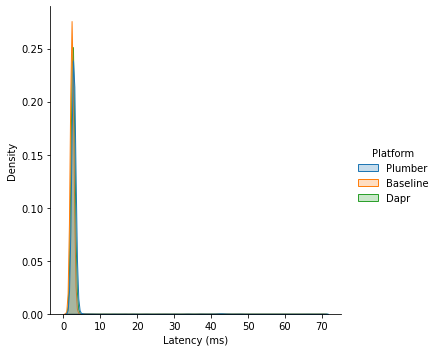

In [6]:
sns.displot(df, x="Latency (ms)", hue="Platform", kind="kde", fill=True)

In [34]:
df.describe()

,Latency (ms)
count,30000.000000
mean,2.670680
std,2.778024
min,1.291234
25%,2.231065
50%,2.440632
75%,2.677774
max,70.250253


<AxesSubplot:xlabel='Platform', ylabel='Latency (ms)'>

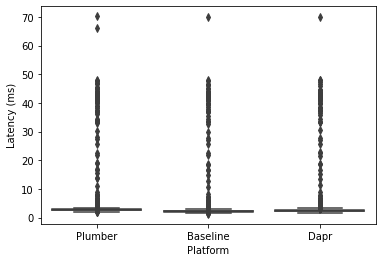

In [35]:
sns.boxplot(data=df, x="Platform", y="Latency (ms)")

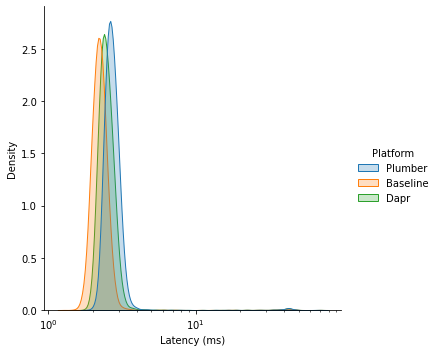

In [11]:
sns.displot(df, x="Latency (ms)", hue="Platform", kind="kde", fill=True, log_scale=True)

<AxesSubplot:xlabel='Latency (ms)', ylabel='Proportion'>

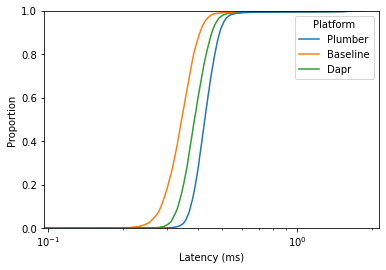

In [30]:
sns.ecdfplot(data=df, x="Latency (ms)", hue="Platform", log_scale=True)

In [29]:
df.shape

(30000, 4)

In [42]:
# Obvious issue with outliers for visualizations: remove them through IQR method
plat_dfs = []
for plat in df["Platform"].unique():
    print(plat)
    df_plat = df[df["Platform"] == plat]
    q1 = df_plat.quantile(0.25)["Latency (ms)"]
    q3 = df_plat.quantile(0.75)["Latency (ms)"]
    iqr = q3 - q1
    print(df_plat.shape)
    df_plat = df_plat[~((df["Latency (ms)"] < (q1 - 1.5 * iqr)) | (df["Latency (ms)"] > (q3 + 1.5 * iqr)))].reset_index(drop=True)
    print(df_plat.shape)
    plat_dfs.append(df_plat)

filtered_df = pd.concat(plat_dfs)


Plumber
(10000, 4)
(9783, 4)
Baseline
(10000, 4)
(9818, 4)
Dapr
(10000, 4)
(9797, 4)


<ipython-input-42-cb4ad0cf4b78>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_plat = df_plat[~((df["Latency (ms)"] < (q1 - 1.5 * iqr)) | (df["Latency (ms)"] > (q3 + 1.5 * iqr)))].reset_index(drop=True)
<ipython-input-42-cb4ad0cf4b78>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_plat = df_plat[~((df["Latency (ms)"] < (q1 - 1.5 * iqr)) | (df["Latency (ms)"] > (q3 + 1.5 * iqr)))].reset_index(drop=True)
<ipython-input-42-cb4ad0cf4b78>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_plat = df_plat[~((df["Latency (ms)"] < (q1 - 1.5 * iqr)) | (df["Latency (ms)"] > (q3 + 1.5 * iqr)))].reset_index(drop=True)


In [79]:
filtered_df.groupby(["Platform"]).describe()

latency (ms)                                                    \
                count      mean       std       min       25%       50%   
Platform                                                                  
Baseline       9818.0  2.214440  0.232366  1.560981  2.047219  2.201952   
Dapr           9797.0  2.459035  0.255296  1.727504  2.270767  2.430236   
Plumber        9783.0  2.683987  0.261814  1.937981  2.491717  2.658401   

                              
               75%       max  
Platform                      
Baseline  2.371029  2.871656  
Dapr      2.628614  3.193542  
Plumber   2.859193  3.446367

In [43]:
# preprocessing for catplot
df_metrics = pd.DataFrame(columns=["Metric", "Platform", "Latency (ms)"])
for plat in df["Platform"].unique():
    plat_df = df[df["Platform"] == plat]
    df_metrics = df_metrics.append({"Metric": "Median", "Platform": plat, "Latency (ms)": plat_df.quantile(0.5)["Latency (ms)"]}, ignore_index=True) 
    df_metrics = df_metrics.append({"Metric": "90th Percentile", "Platform": plat, "Latency (ms)": plat_df.quantile(0.9)["Latency (ms)"]}, ignore_index=True) 
    df_metrics = df_metrics.append({"Metric": "99th Percentile", "Platform": plat, "Latency (ms)": plat_df.quantile(0.99)["Latency (ms)"]}, ignore_index=True) 

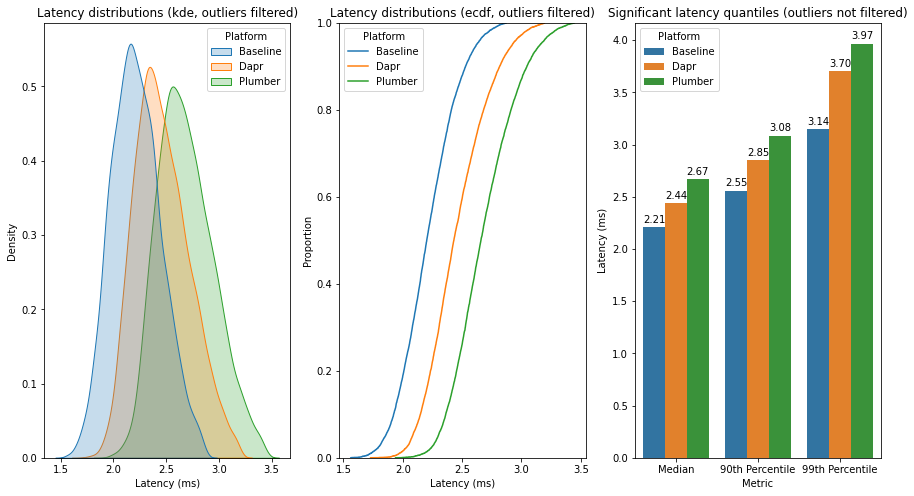

In [80]:

f, axes = plt.subplots(1, 3, figsize=(15,8))
h_order = ["Baseline", "Dapr", "Plumber"]
sns.kdeplot(data=filtered_df, x="Latency (ms)", hue="Platform", fill=True, ax=axes[0], hue_order=h_order)
sns.ecdfplot(data=filtered_df, x="Latency (ms)", hue="Platform", ax=axes[1], hue_order=h_order)
sns.barplot(
    data=df_metrics,
    x="Metric", y="Latency (ms)", hue="Platform",
    hue_order=h_order,
    ax = axes[2]
)

axes[0].title.set_text('Latency distributions (kde, outliers filtered)')
axes[1].title.set_text('Latency distributions (ecdf, outliers filtered)')
axes[2].title.set_text('Significant latency quantiles (outliers not filtered)')


def add_value_labels(ax, spacing=3):
    """Add labels to the end of each bar in a bar chart.

    Arguments:
        ax (matplotlib.axes.Axes): The matplotlib object containing the axes
            of the plot to annotate.
        spacing (int): The distance between the labels and the bars.
    """

    # For each bar: Place a label
    for rect in ax.patches:
        # Get X and Y placement of label from rect.
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        # Number of points between bar and label. Change to your liking.
        space = spacing
        # Vertical alignment for positive values
        va = 'bottom'

        # If value of bar is negative: Place label below bar
        if y_value < 0:
            # Invert space to place label below
            space *= -1
            # Vertically align label at top
            va = 'top'

        # Use Y value as label and format number with one decimal place
        label = "{:.2f}".format(y_value)

        # Create annotation
        ax.annotate(
            label,                      # Use `label` as label
            (x_value, y_value),         # Place label at end of the bar
            xytext=(0, space),          # Vertically shift label by `space`
            textcoords="offset points", # Interpret `xytext` as offset in points
            ha='center',                # Horizontally center label
            va=va)                      # Vertically align label differently for
                                        # positive and negative values.


# Call the function above. All the magic happens there.
add_value_labels(axes[2])


In [ ]:
g = sns.catplot(
    data=df_metrics, kind="bar",
    x="Metric", y="Latency (ms)", hue="Platform",
    hue_order=["Baseline", "Dapr", "Plumber"],
    ax = axs[1,0]
)
ax = g.facet_axis(0, 0)

for c in ax.containers:
    labels = [f'{(v.get_height()):.2f}ms' for v in c]
    ax.bar_label(c, labels=labels, label_type='edge', fontsize='x-small')